In [1]:
# https://www.digitalocean.com/community/tutorials/training-validation-and-accuracy-in-pytorch

## Setup

In [12]:
import numpy as np
from datasets import load_dataset
import sys
import torch

import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
from src.datasets.imagenet1k import make_imagenet1k as asdf
from src import helper
from src.models import vision_transformer
from datasets import Dataset, DatasetDict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from src.transforms import make_transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split

%load_ext autoreload
%autoreload 2

## Load in target encoder

In [2]:
CHECKPOINT_FILE = './checkpoint/IN1K-vit.h.14-300e.pth.tar'
checkpoint = torch.load(CHECKPOINT_FILE, map_location=torch.device('cpu'))
target_encoder_weights = checkpoint['target_encoder']
del checkpoint
import gc
gc.collect()

/tmp/ipykernel_2827/3144561750.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_FILE, map_location=torch.device('cpu'))


9

## Copying what Assran et. al did in their code, and just setting up the model to not require gradient calculations

In [3]:
import copy
d = torch.device('cuda:0')
torch.cuda.set_device(d)

encoder, predictor = helper.init_model(
    device = d,
    patch_size=14,
    crop_size=224,
    pred_depth=12,
    pred_emb_dim=384,
    model_name='vit_huge')

target_encoder = copy.deepcopy(encoder)

target_encoder_weights = {k.replace('module.', ''): v for k, v in target_encoder_weights.items()}

target_encoder.eval()

# Just want to train the linear classifier part.
for p in target_encoder.parameters():
    p.requires_grad = False

msg = target_encoder.load_state_dict(target_encoder_weights)

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  )
  (blocks): ModuleList(
    (0-31): 32 x Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
)


## Encode Classify Net is the target encoder from IJEPA with one hidden fully connected layer and the output layer. Very simple!

In [4]:
from my_code.NN import EncodeClassifyNet

NN = EncodeClassifyNet(target_encoder)
NN = NN.to(d)

## Make train, val, and test

In [5]:
cifar10 = load_dataset("cifar10")

full_train_set = cifar10['train']

train_size = int(0.9 * len(full_train_set))
val_size   = len(full_train_set) - train_size

train_set, val_set = random_split(full_train_set, [train_size, val_size])

test_set = cifar10['test']

## Make small dataset to overfit for debugging

In [6]:
small_size = 128 * 20
small_train, _ = random_split(train_set, [small_size, len(train_set) - small_size])

### More copying of Assran et al. Just resizing and cropping, no other data augmentations

In [7]:
from my_code.data_loader import Transformed_Cifar

transform = make_transforms(
crop_size=224,
crop_scale=[0.3, 1.0],
gaussian_blur=False,
horizontal_flip=False,
color_distortion=False,
color_jitter=0.0)

transform_with_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transform
])

INFO:root:making imagenet data transforms


In [8]:
transformed_train = Transformed_Cifar(full_train_set, transform_with_resize)
transformed_test = Transformed_Cifar(test_set, transform_with_resize)

## Using some ideas from assignment 5 'GANs-PyTorch.ipynb' and pytorch tutorial from TAs

In [9]:
def accuracy(model, loader, dataset_len):
    model.eval()
    num_correct = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to('cuda'), labels.to('cuda')
            predictions = torch.argmax(model(imgs), dim=1)
            num_correct += torch.sum(predictions == labels)

    return (num_correct / dataset_len).item()

In [10]:
def training_loop(model, loader, optimizer, loss_function, num_epochs=1):
    model.train()
    losses = []
    for epoch in range(0, num_epochs):
        for imgs, labels in loader:
            
            imgs, labels = imgs.to('cuda'), labels.to('cuda')

            forward = model(imgs)

            loss = loss_function(forward, labels)
            losses.append(loss.item())
            print("Loss: ", loss.item())
            
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    plt.title("Loss over time")
    plt.ylabel("Loss")
    plt.xlabel("Iterations")
    plt.plot(losses)
    plt.show()
    return losses


# Training the model for 1 epoch only

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(NN.parameters(), lr=0.0001)
training_loader = DataLoader(transformed_train, batch_size=64, shuffle=True)

Loss:  1.8028786182403564
Loss:  1.8013792037963867
Loss:  1.6686291694641113
Loss:  1.5849230289459229
Loss:  1.446239948272705
Loss:  1.4673473834991455
Loss:  1.4831781387329102
Loss:  1.5845732688903809
Loss:  1.3703018426895142
Loss:  1.3127670288085938
Loss:  1.3887447118759155
Loss:  1.287715196609497
Loss:  1.3350533246994019
Loss:  1.268109917640686
Loss:  1.340124487876892
Loss:  1.2336126565933228
Loss:  1.2761377096176147
Loss:  1.0601531267166138
Loss:  1.2585614919662476
Loss:  0.9626018404960632
Loss:  0.9225285053253174
Loss:  0.9852253198623657
Loss:  0.8318812847137451
Loss:  1.040759801864624
Loss:  0.9610863327980042
Loss:  1.0246241092681885
Loss:  0.8576679229736328
Loss:  0.9702606201171875
Loss:  0.8460181951522827
Loss:  0.968640923500061
Loss:  0.8415711522102356
Loss:  0.9385539293289185
Loss:  0.8754140734672546
Loss:  0.8852578401565552
Loss:  0.8948682546615601
Loss:  0.8840075135231018
Loss:  0.8029691576957703
Loss:  0.9469744563102722
Loss:  0.776812136

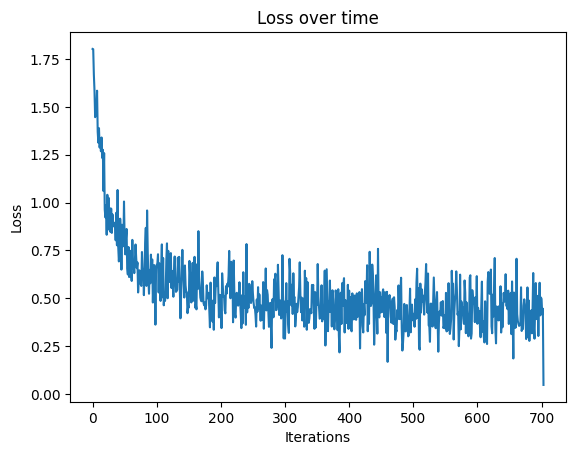

Accuracy after one epoch:  0.8514999747276306


In [ ]:

losses = training_loop(NN, training_loader, optimizer=optimizer, loss_function=loss_fn, num_epochs=1)
test = DataLoader(transformed_test, batch_size=64, shuffle=False)
print("Accuracy after one epoch: ", accuracy(NN, test, len(transformed_test)))

## Where it gets REALLY interesting, is without a hidden layer, it performs exceptionally well still. Crazy!

Loss:  2.3008251190185547
Loss:  2.2662508487701416
Loss:  2.251525402069092
Loss:  2.162971019744873
Loss:  2.0414841175079346
Loss:  2.078739643096924
Loss:  1.9511728286743164
Loss:  1.9214155673980713
Loss:  1.8621805906295776
Loss:  1.6647918224334717
Loss:  1.6384925842285156
Loss:  1.5781512260437012
Loss:  1.5711474418640137
Loss:  1.5407599210739136
Loss:  1.4449156522750854
Loss:  1.395910382270813
Loss:  1.4334893226623535
Loss:  1.4535818099975586
Loss:  1.1690952777862549
Loss:  1.2441164255142212
Loss:  1.1618740558624268
Loss:  1.139898419380188
Loss:  1.056215763092041
Loss:  1.08406662940979
Loss:  1.3217267990112305
Loss:  1.0768595933914185
Loss:  0.9247945547103882
Loss:  0.9797586798667908
Loss:  0.9498594999313354
Loss:  1.0898593664169312
Loss:  0.9502310752868652
Loss:  1.0568829774856567
Loss:  1.0244818925857544
Loss:  1.0453979969024658
Loss:  1.0170862674713135
Loss:  0.978543221950531
Loss:  1.0034795999526978
Loss:  0.8368410468101501
Loss:  0.889202773571

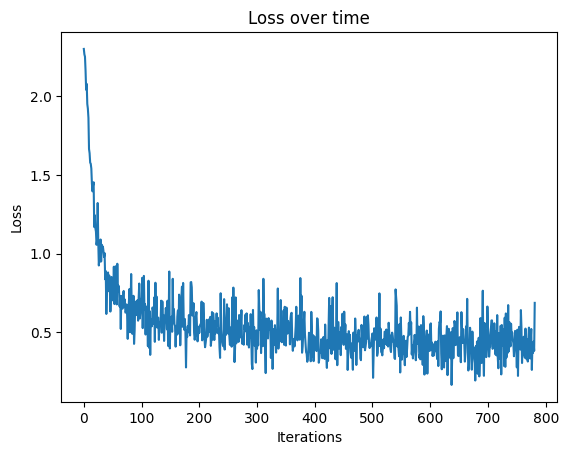

Accuracy after one epoch:  0.8547999858856201


In [23]:
from my_code.NN import EncodeLNClassify

NN = EncodeLNClassify(target_encoder)
NN = NN.to(d)
optimizer = optim.Adam(NN.parameters(), lr=0.00005)

losses = training_loop(NN, training_loader, optimizer=optimizer, loss_function=loss_fn, num_epochs=1)
test = DataLoader(transformed_test, batch_size=64, shuffle=False)
print("Accuracy after one epoch: ", accuracy(NN, test, len(transformed_test)))

In [25]:
train = DataLoader(transformed_train, batch_size=64, shuffle=False)
print("Training accuracy after one epoch: ", accuracy(NN, train, len(transformed_train)))

Training accuracy after one epoch:  0.8597999811172485
